In [1]:
from collections import Counter, deque
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from utils.storage.truth_db import SQLiteTruthSaver
from utils.storage.bluesky_db import SQLiteBlueSkySaver

ModuleNotFoundError: No module named 'matplotlib.backends.registry'

## 0. Extracting Graphs and Subgraphs

In [2]:
# Truth_Graph = SQLiteTruthSaver().extract_network()
# nx.write_gexf(Truth_Graph, "truth.gexf")
#
# Bluesky_Graph = SQLiteBlueSkySaver().extract_network()
# nx.write_gexf(Bluesky_Graph, "bluesky.gexf")
#
# Truth_TopGraph = SQLiteTruthSaver().extract_network(top_k=1000)
# nx.write_gexf(Truth_TopGraph, "truth_top1000.gexf")
#
# Bluesky_TopGraph = SQLiteBlueSkySaver().extract_network(top_k=1000)
# nx.write_gexf(Bluesky_TopGraph, "bluesky_top1000.gexf")

Truth_Graph = nx.read_gexf("truth.gexf")
Bluesky_Graph = nx.read_gexf("bluesky.gexf")
Truth_TopGraph = nx.read_gexf("truth_top1000.gexf")
Bluesky_TopGraph = nx.read_gexf("bluesky_top1000.gexf")

## 1. Basic Measures

Order, Size, Degree Distribution and Connected Components

In [ ]:
def gini_coeff(x):
    x = np.sort(np.array(x))
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def analyze_graph(G, color):
    print(f"{G.order()} Nodes and {G.size()} Edges")
    print(f"Density is {nx.density(G)}")

    degree = dict(G.degree())
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    degree_values = list(degree.values())
    in_degree_values = list(in_degree.values())
    out_degree_values = list(out_degree.values())

    # Calculate Lorenz Curve for the Distribution of Posts between Users
    posts_count_dict = np.sort([
        node['posts_count']
        for node_id, node in G.nodes(data=True)
    ])
    posts_count_cdf = np.cumsum(posts_count_dict) / sum(posts_count_dict)
    lam = nx.density(G) * (G.order() - 1)
    poisson_posts_count = np.sort(np.random.poisson(lam=lam, size=len(posts_count_dict)))
    poisson_posts_count_cdf = np.cumsum(poisson_posts_count) / sum(poisson_posts_count)


    count, bins = np.histogram(
        in_degree_values,
        bins=np.arange(0, max(in_degree_values) + 2)
    )
    pdf = count / G.order()
    ccdf = 1.0 - np.cumsum(pdf)

    ccdf[-1] = 0.0 # Fixes floating point error

    print(f"Nodes with in degree zero: {len([x for x in in_degree_values if x == 0])}")

    # Compute connected component sizes
    cc = list(nx.weakly_connected_components(G))
    component_sizes = sorted([len(c) for c in cc], reverse=True)
    components_by_size = Counter(component_sizes)

    # Print stats
    print(f"Min Degree: {min(degree_values)}")
    print(f"Max Degree: {max(degree_values)}")
    print(f"Average Degree: {np.mean(degree_values):.2f}")
    print(f"Average In-Degree: {np.mean(in_degree_values):.2f}")
    print(f"Average Out-Degree: {np.mean(out_degree_values):.2f}")

    print(f"There are {len(cc)} Connected Components:")
    for component in cc[:min(3, len(cc))]:
        print(f"\tConnected Component of size: {len(component)} ({len(component)/G.order():.2%})")
    print("\t...")

    top_in = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by In-Degree:")
    for node, deg in top_in:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: In-Degree = {deg}")

    top_out = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Out-Degree:")
    for node, deg in top_out:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Out-Degree = {deg}")

    # Degree Centrality
    deg_centrality = nx.degree_centrality(G)
    top_deg_centrality = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Degree Centrality:")
    for node, centrality in top_deg_centrality:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Degree Centrality = {centrality:.4f}")


    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-1], pdf, marker='o', linestyle='--', label="Degree PDF", color=color)
    #plt.xscale("log")
    #plt.yscale("log")
    plt.title("In-Degree PDF")
    plt.xlabel("Degree")
    plt.ylabel("PDF - P(X=x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-1], ccdf, marker='o', linestyle='--', label="Degree CCDF", color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("In-Degree CCDF")
    plt.xlabel("Degree")
    plt.ylabel("CCDF - P(X>x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.scatter(np.arange(len(posts_count_cdf)) / (len(posts_count_dict) - 1), posts_count_cdf, marker='o', linestyle='--', label="Network", color=color)
    plt.scatter(np.arange(len(poisson_posts_count_cdf)) / (len(poisson_posts_count) - 1), poisson_posts_count_cdf, marker='o', linestyle='--', label="Erdos-Renyi Random Network", color="gray")
    plt.plot([0, 1], [0, 1], 'k--', label="Equality Line")
    plt.title("Lorenz Curve of Posts per User")
    plt.xlabel("Cum. % of Users")
    plt.ylabel("Cum. % of Posts")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Gini Coefficient: {gini_coeff(posts_count_dict):.5f}")

    plt.figure(figsize=(7, 4))
    plt.scatter(list(components_by_size.keys()), list(components_by_size.values()), color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Weakly Connected Components")
    plt.xlabel("Component Size")
    plt.ylabel("# of Components")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(list(deg_centrality.values()), bins=50, log=True, color=color, alpha=0.7)
    plt.title("Distribuzione Degree Centrality")
    plt.xlabel("Degree Centrality")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


In [ ]:
analyze_graph(Truth_Graph, color='red')

14735 Nodes and 17607 Edges
Density is 8.109882435492535e-05
Nodes with in degree zero: 13946
Min Degree: 1
Max Degree: 1148
Average Degree: 2.39
Average In-Degree: 1.19
Average Out-Degree: 1.19
There are 240 Connected Components:
	Connected Component of size: 13957 (94.72%)
	Connected Component of size: 8 (0.05%)
	Connected Component of size: 7 (0.05%)
	...
Top 3 Nodes by In-Degree:
	Node atrupar.com https://bsky.app/profile/atrupar.com: In-Degree = 1148
	Node mollyjongfast.bsky.social https://bsky.app/profile/mollyjongfast.bsky.social: In-Degree = 817
	Node artcandee.bsky.social https://bsky.app/profile/artcandee.bsky.social: In-Degree = 778
Top 3 Nodes by Out-Degree:
	Node mccarthypm.bsky.social https://bsky.app/profile/mccarthypm.bsky.social: Out-Degree = 22
	Node robertomitchelli.bsky.social https://bsky.app/profile/robertomitchelli.bsky.social: Out-Degree = 17
	Node nameless62.bsky.social https://bsky.app/profile/nameless62.bsky.social: Out-Degree = 17
Top 3 Nodes by Degree Centr

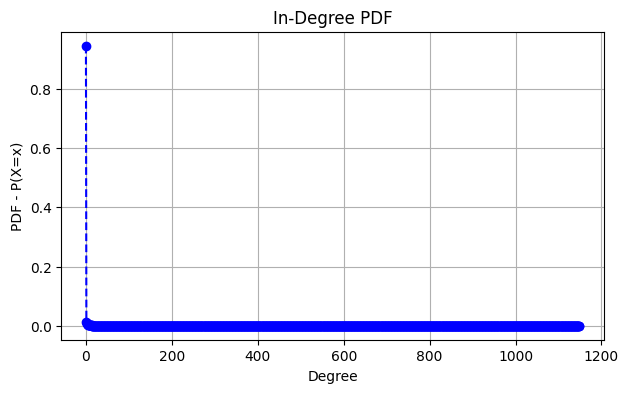

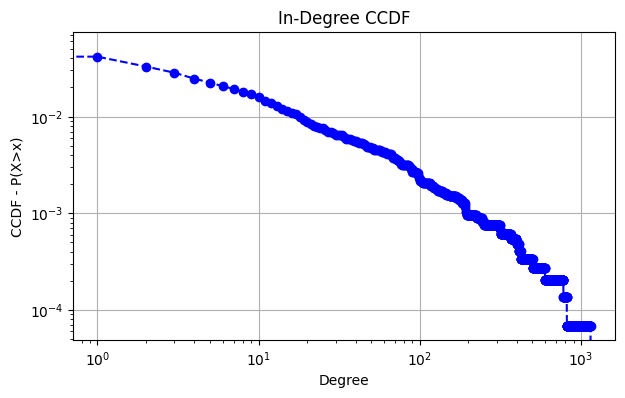

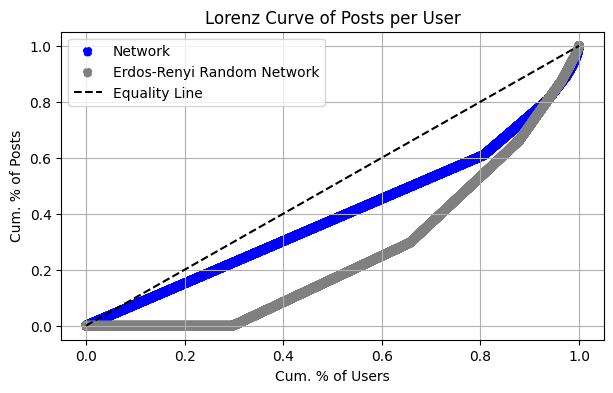

Gini Coefficient: 0.21216


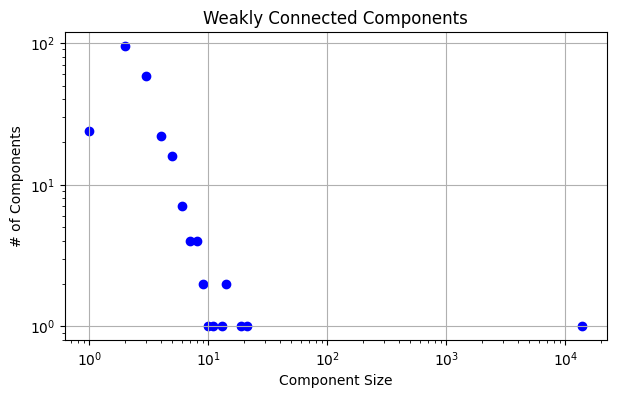

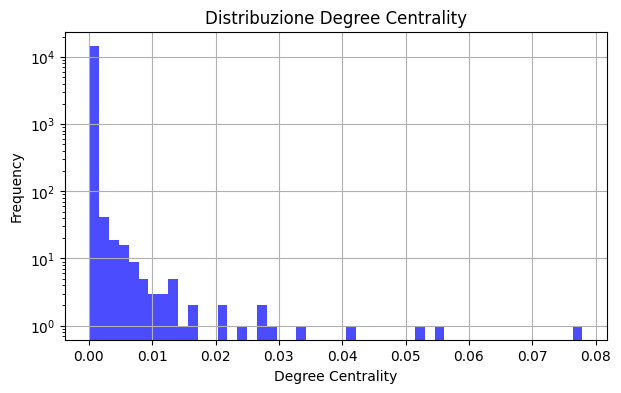

In [5]:
analyze_graph(Bluesky_Graph, color='blue')

993 Nodes and 4384 Edges
Density is 0.004450508397492122
Nodes with in degree zero: 271
Min Degree: 1
Max Degree: 641
Average Degree: 8.83
Average In-Degree: 4.41
Average Out-Degree: 4.41
There are 2 Connected Components:
	Connected Component of size: 992 (99.90%)
	Connected Component of size: 1 (0.10%)
	...
Top 3 Nodes by In-Degree:
	Node realDonaldTrump https://truthsocial.com/@realDonaldTrump: In-Degree = 641
	Node joemccuiston https://truthsocial.com/@joemccuiston: In-Degree = 210
	Node IStandWithTrump47 https://truthsocial.com/@IStandWithTrump47: In-Degree = 149
Top 3 Nodes by Out-Degree:
	Node DaKine17 https://truthsocial.com/@DaKine17: Out-Degree = 99
	Node Gscott62 https://truthsocial.com/@Gscott62: Out-Degree = 24
	Node nativecslifornian https://truthsocial.com/@nativecslifornian: Out-Degree = 24
Top 3 Nodes by Degree Centrality:
	Node realDonaldTrump https://truthsocial.com/@realDonaldTrump: Degree Centrality = 0.6462
	Node joemccuiston https://truthsocial.com/@joemccuiston: 

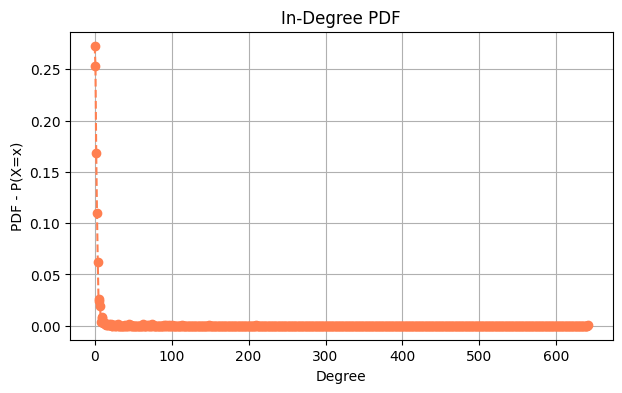

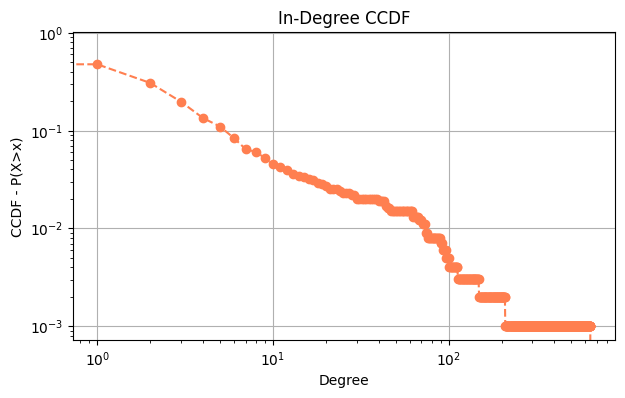

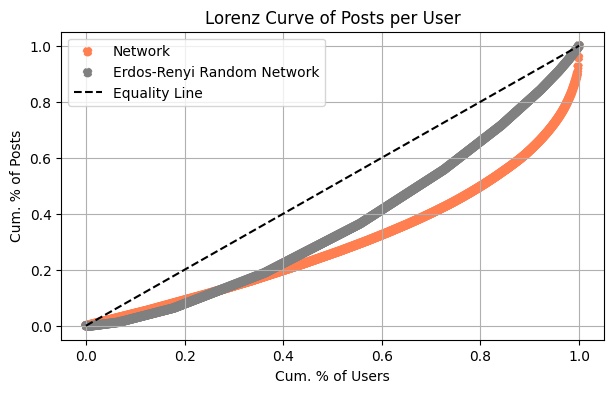

Gini Coefficient: 0.40014


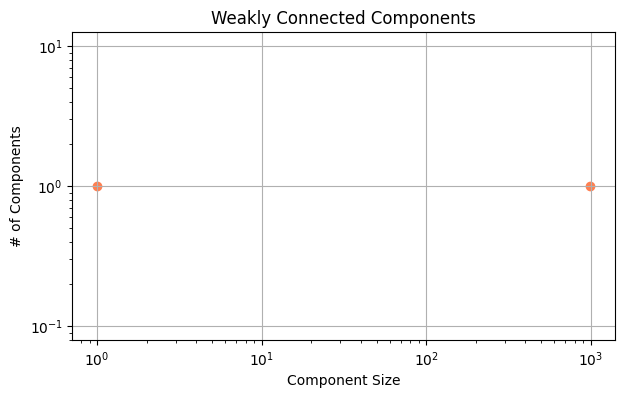

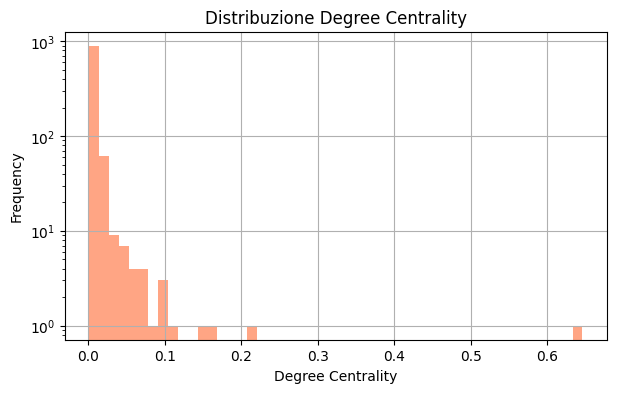

In [6]:
analyze_graph(Truth_TopGraph, color='coral')

925 Nodes and 1787 Edges
Density is 0.0020907920907920906
Nodes with in degree zero: 811
Min Degree: 1
Max Degree: 179
Average Degree: 3.86
Average In-Degree: 1.93
Average Out-Degree: 1.93
There are 15 Connected Components:
	Connected Component of size: 910 (98.38%)
	Connected Component of size: 1 (0.11%)
	Connected Component of size: 1 (0.11%)
	...
Top 3 Nodes by In-Degree:
	Node atrupar.com https://bsky.app/profile/atrupar.com: In-Degree = 179
	Node mollyjongfast.bsky.social https://bsky.app/profile/mollyjongfast.bsky.social: In-Degree = 147
	Node artcandee.bsky.social https://bsky.app/profile/artcandee.bsky.social: In-Degree = 129
Top 3 Nodes by Out-Degree:
	Node mccarthypm.bsky.social https://bsky.app/profile/mccarthypm.bsky.social: Out-Degree = 11
	Node nameless62.bsky.social https://bsky.app/profile/nameless62.bsky.social: Out-Degree = 10
	Node robertomitchelli.bsky.social https://bsky.app/profile/robertomitchelli.bsky.social: Out-Degree = 10
Top 3 Nodes by Degree Centrality:
	No

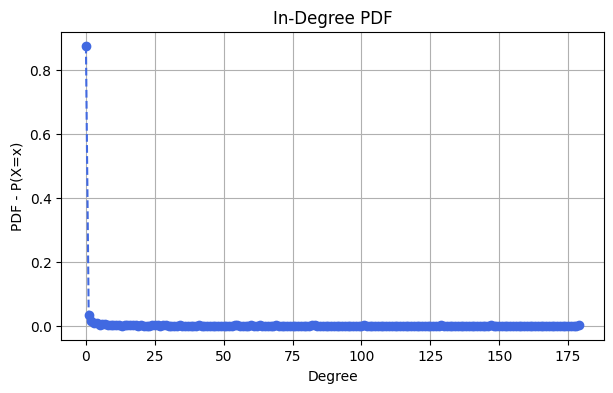

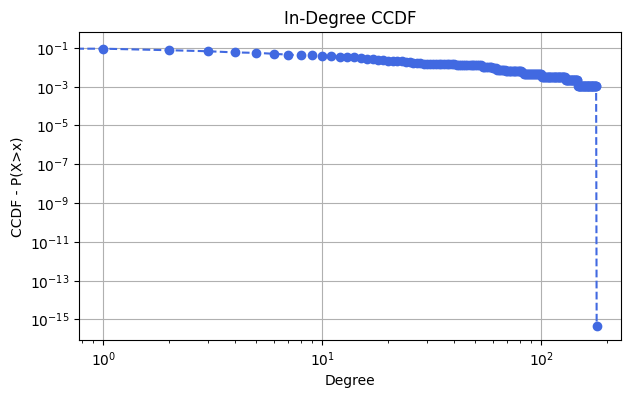

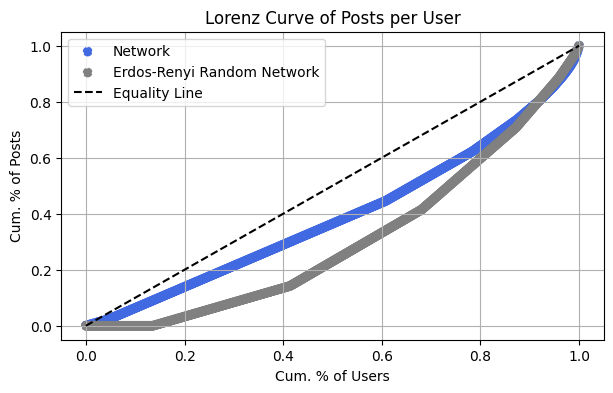

Gini Coefficient: 0.21343


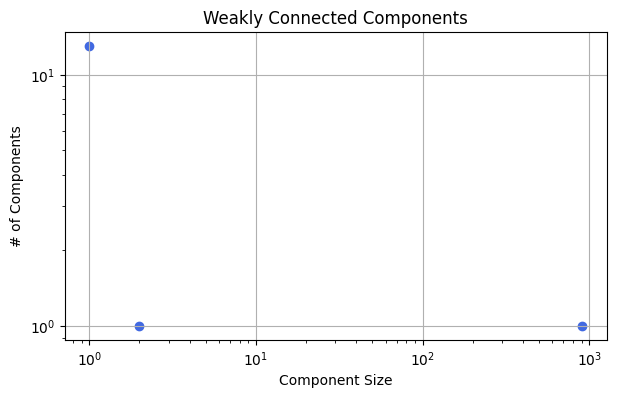

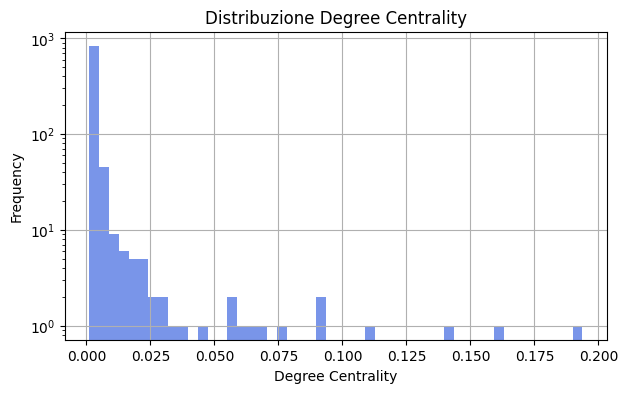

In [7]:
analyze_graph(Bluesky_TopGraph, color='royalblue')

In [121]:
def bidirectional_forest_fire_sample(G, max_nodes, seed_node=None, p_forward=0.7):
    """Compared to traditional Forest Fire Sampling, the neighbors selected for burning can either be at the end of out-links or in-links"""
    if seed_node is None:
        seed_node = random.choice(list(G.nodes))

    sampled_nodes = {seed_node}
    queue = [seed_node]

    while queue and len(sampled_nodes) < max_nodes:
        current = queue.pop(0)

        # Combine outgoing and incoming edges
        try:
            neighbors = set(G.successors(current)) | set(G.predecessors(current))
        except:
            neighbors = set(G.neighbors(current))  # Fallback for undirected

        neighbors -= sampled_nodes
        if not neighbors:
            continue

        # Burn a random number of neighbors (at least 1 if possible)
        burn_count = max(1, int(len(neighbors) * p_forward))
        burn_count = min(burn_count, len(neighbors))  # Avoid overflow

        neighbors = list(neighbors)
        random.shuffle(neighbors)
        for neighbor in neighbors[:burn_count]:
            if neighbor not in sampled_nodes:
                sampled_nodes.add(neighbor)
                queue.append(neighbor)
                if len(sampled_nodes) >= max_nodes:
                    break

    return G.subgraph(sampled_nodes).copy()

In [122]:
Truth_Subgraph = bidirectional_forest_fire_sample(Truth_Graph, max_nodes=len(Bluesky_Graph.nodes()))
# Bluesky_Subgraph = forest_fire_sample(Bluesky_Graph, max_nodes=1000)

14735 Nodes and 29721 Edges
Density is 0.00013689658423653866
Nodes with in degree zero: 11154
Min Degree: 1
Max Degree: 10062
Average Degree: 4.03
Average In-Degree: 2.02
Average Out-Degree: 2.02
There are 1 Connected Components:
	Connected Component of size: 14735 (100.00%)
	...
Top 3 Nodes by In-Degree:
	Node realDonaldTrump https://truthsocial.com/@realDonaldTrump: In-Degree = 10062
	Node joemccuiston https://truthsocial.com/@joemccuiston: In-Degree = 3082
	Node OksanaTrump https://truthsocial.com/@OksanaTrump: In-Degree = 742
Top 3 Nodes by Out-Degree:
	Node DaKine17 https://truthsocial.com/@DaKine17: Out-Degree = 537
	Node char_smi3 https://truthsocial.com/@char_smi3: Out-Degree = 100
	Node Yatti420 https://truthsocial.com/@Yatti420: Out-Degree = 52
Top 3 Nodes by Degree Centrality:
	Node realDonaldTrump https://truthsocial.com/@realDonaldTrump: Degree Centrality = 0.6829
	Node joemccuiston https://truthsocial.com/@joemccuiston: Degree Centrality = 0.2097
	Node DaKine17 https://t

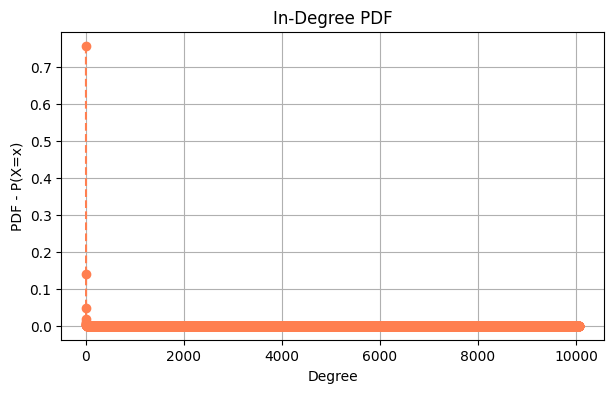

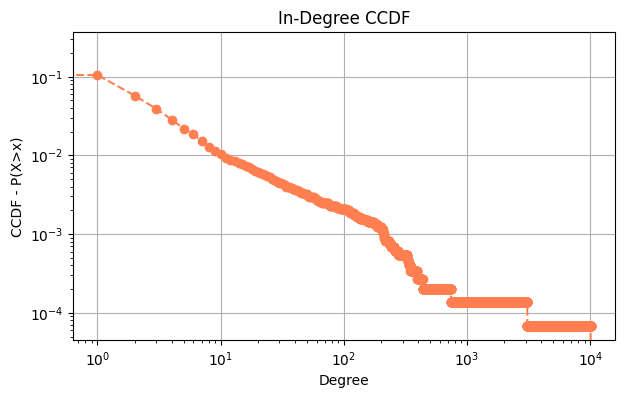

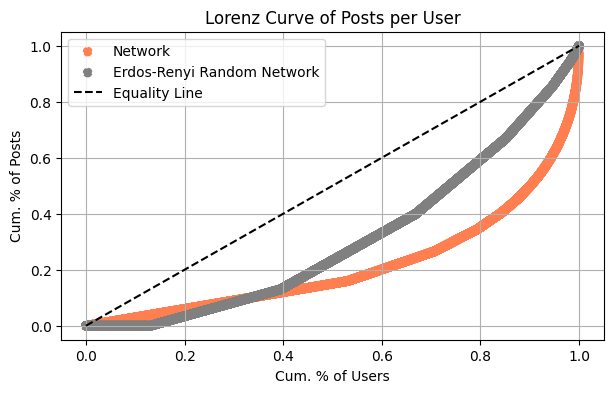

Gini Coefficient: 0.56987


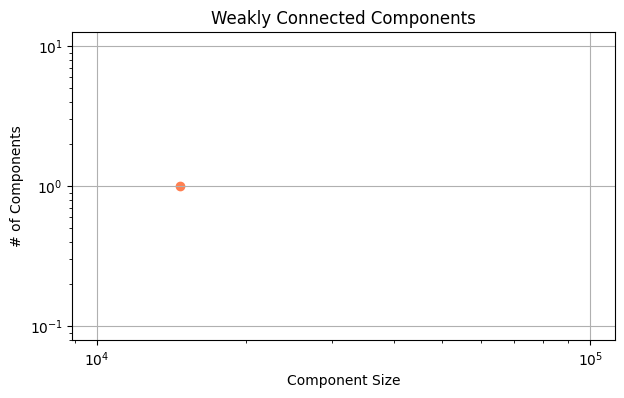

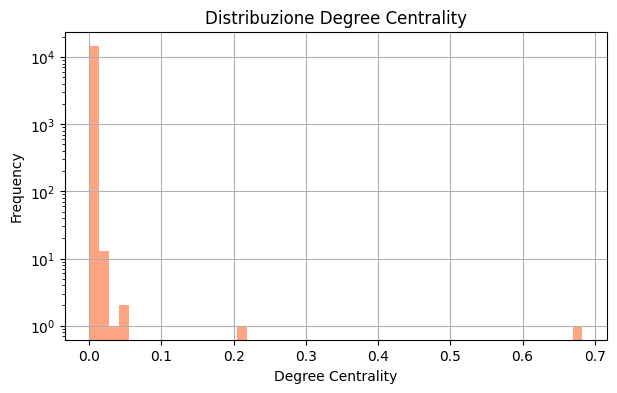

In [123]:
analyze_graph(Truth_Subgraph, color='coral')

In [113]:
nx.write_gexf(Truth_Subgraph, "truth_sub.gexf")

In [ ]:
# So the graphs are:

# bluesky.gexf (14k nodes, 17k edges)
# truth_sub.gexf (14k nodes, 29k edges) - obtained with forest fire sampling

# Now:
#